In [24]:
%matplotlib inline
from pymongo import MongoClient
import pymongo
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as mstyle
mstyle.use('bmh')
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=10,10

In [25]:
db=MongoClient(host='localhost',port=27017).mydb.cwdb
df = pd.DataFrame(list(db.find({}).sort([('date', pymongo.ASCENDING)])))

In [26]:
df.head()

,_id,date,price,marker,change
0,5ec717b6e7c9ae5fdfdb969b,1986-01-03,26.00,WTI,0.017214
1,5ec717b6e7c9ae5fdfdb969c,1986-01-06,26.53,WTI,0.020385
2,5ec717b6e7c9ae5fdfdb969d,1986-01-07,25.85,WTI,-0.025631
3,5ec717b6e7c9ae5fdfdb969e,1986-01-08,25.87,WTI,0.000774
4,5ec717b6e7c9ae5fdfdb969f,1986-01-09,26.03,WTI,0.006185


## Залежність ціни на паливо від сорту палива

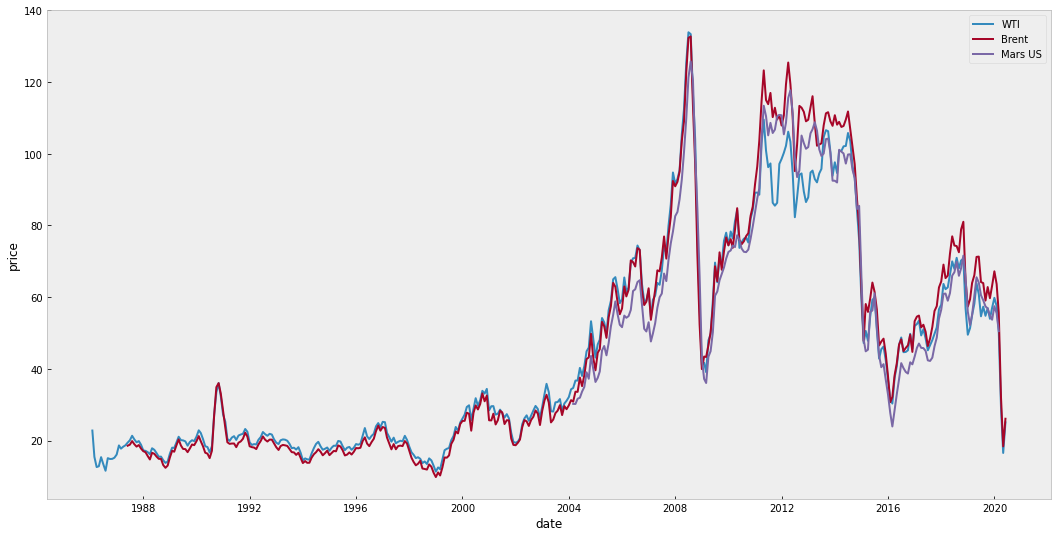

In [27]:
df.set_index('date', drop=False, inplace=True)
df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
fig, ax = plt.subplots(figsize=(18, 9))
for oil_sort in df['marker'].unique():
    subDf = df[df['marker'] == oil_sort]
    subDf = subDf.resample('M').mean()
    ax.plot(subDf['price'], label=oil_sort)
ax.legend(loc='best')
ax.set(xlabel='date', ylabel='price', title='')
ax.grid()
plt.show()

## Залежність приросту ціни на паливо від сорту палива

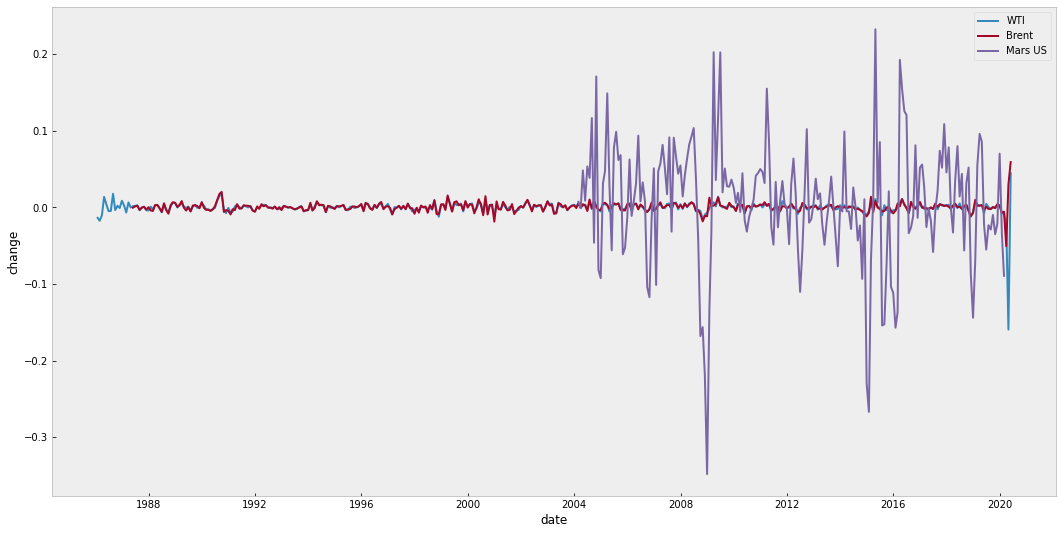

In [28]:
df.set_index('date', drop=False, inplace=True)
df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
fig, ax = plt.subplots(figsize=(18, 9))
for oil_sort in df['marker'].unique():
    subDf = df[df['marker'] == oil_sort]
    subDf = subDf.resample('M').mean()
    ax.plot(subDf['change'], label=oil_sort)
ax.legend(loc='best')
ax.set(xlabel='date', ylabel='change', title='')
ax.grid()
plt.show()

In [29]:
df=pd.DataFrame(list(db.find({'marker': {'$eq': 'Brent'}})))

## Розподіл кількості цін за ціною (за якою ціною паливо продавалось найдовше) для сорту Brent

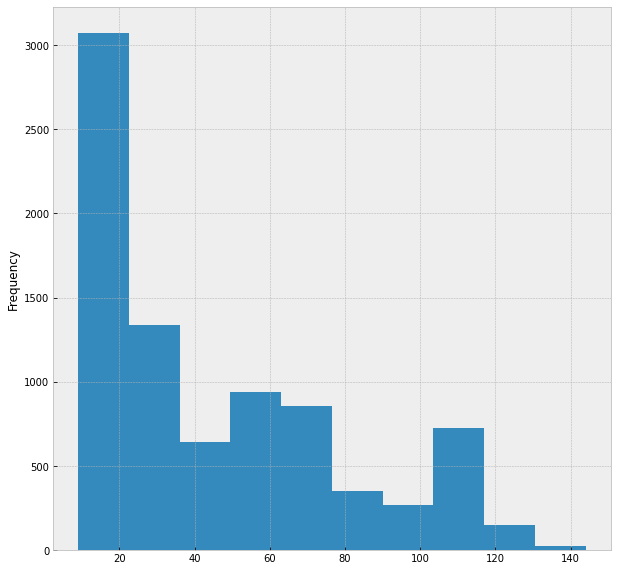

In [30]:
df['price'].plot.hist(bins=10)

## Динаміка росту кількості вакансій за вказаною мовою програмування

**Тенденція** - середнє значення з часом. Наприклад, у цьому випадку ми бачимо, що в середньому ціни на нафту з часом ростуть.

**Сезонність** - коливання в конкретні часові рамки.


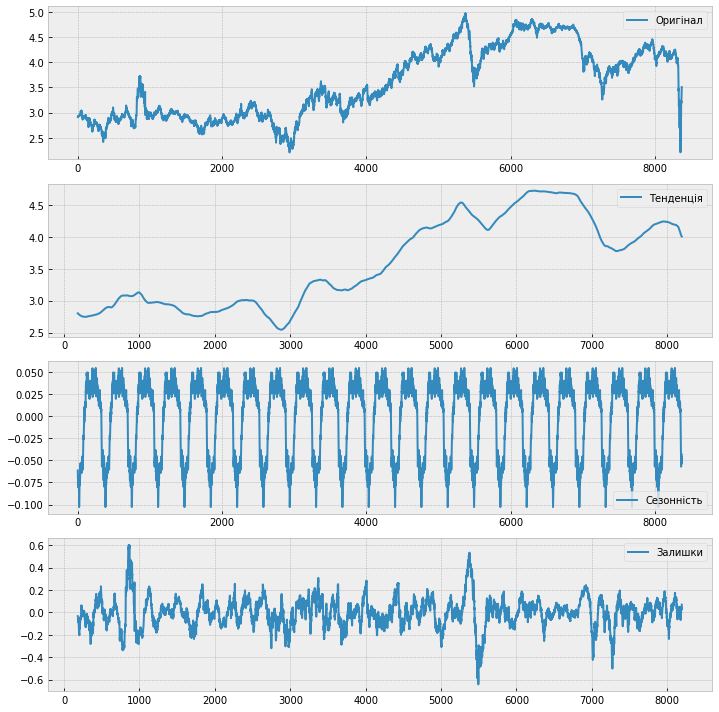

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np

ts_log = np.log(df['price'])

decomposition = seasonal_decompose(ts_log, period = 365)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Оригінал')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Тенденція')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Сезонність')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Залишки')
plt.legend(loc='best')
plt.tight_layout()


## Автокореляційна функція (ACF)

Коефіцієнт кореляції Пірсона - це число від -1 до 1, яке описує відповідно негативну або позитивну кореляцію. Значення нуля вказує на відсутність кореляції.

Я обчислюю співвідношення спостережень часових рядів із спостереженнями з попередніми часовими кроками, які називаються лагами. Оскільки кореляція спостережень часових рядів обчислюється зі значеннями одного і того ж ряду в попередні часи, це називається послідовною кореляцією, або автокореляцією.

Графік автокореляції часових рядів за затримкою називається функцією автокореляції, або абревіатурою ACF. Цей графік іноді називають корелограмою або графіком автокореляції.


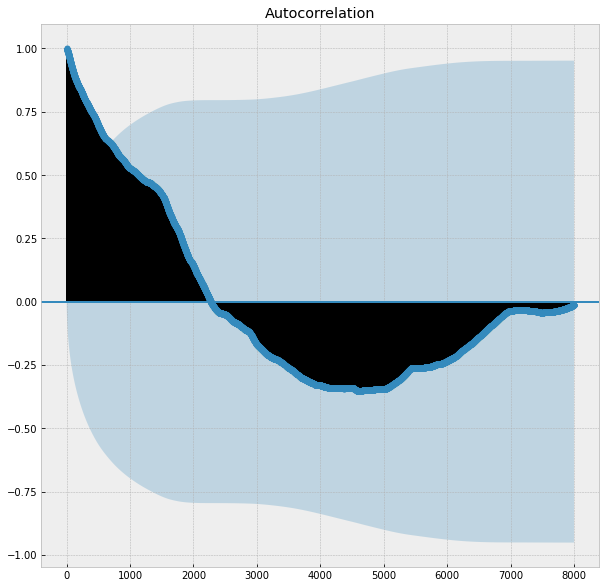

In [32]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df['price'], lags=8000)
plt.show()

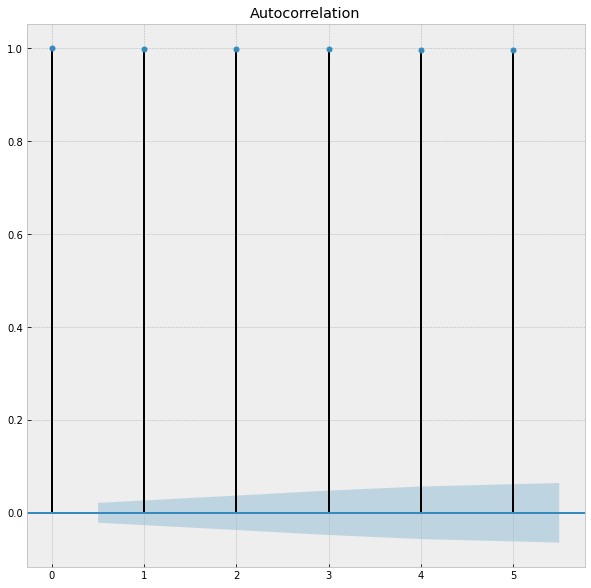

In [33]:

plot_acf(df['price'], lags=5)
plt.show()

## Часткова функція автокореляції (PCAF)

A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.

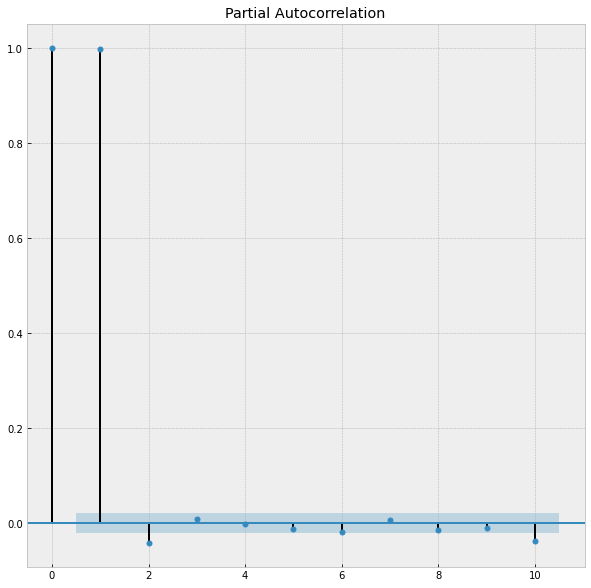

In [34]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(df['price'],lags=10)
plt.show()


На цьому графіку дві лінії по обидві сторони від 0 є довірчими інтервалами. Вони можуть бути використані для визначення значень 'p' та 'q' як:

**p** - значення відставання, коли діаграма PACF вперше перетинає верхній довірчий інтервал. Якщо ви помітили уважно, в цьому випадку p = 2.

**q** - значення відставання, коли діаграма ACF вперше перетинає верхній довірчий інтервал. Якщо ви помітили уважно, в цьому випадку q = 3.


## Модель ARIMA(p,d,q)

/Users/a1/.local/share/virtualenvs/3-2-course-work-db-master-PlpU3n1F/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Text(0.5, 1.0, 'RMSE: 1.3959')

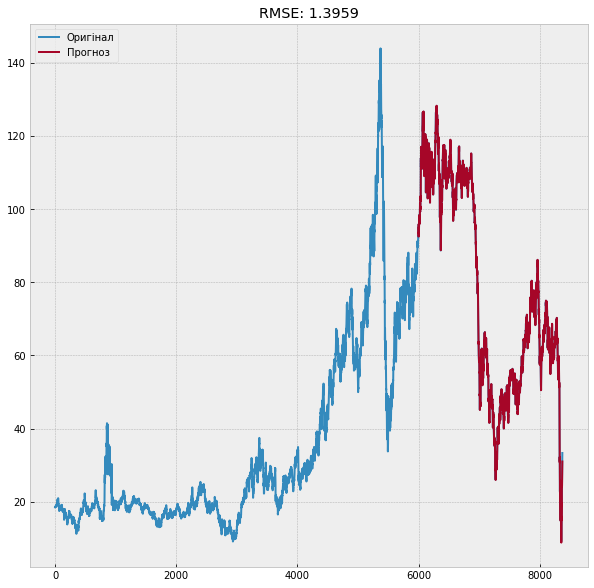

In [46]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(df.price, order=(2, 2, 10))  
results_ARIMA = model.fit(disp=-1)

arima_pred = results_ARIMA.predict(df['price'].index[6000], df['price'].index[-1], typ="levels")


plt.plot(df.price, label='Оригінал')
plt.plot(arima_pred, label='Прогноз')
plt.legend(loc=2)
plt.title('RMSE: %.4f'% np.sqrt(sum((arima_pred-df.price[6000:])**2)/len(df.price[6000:])))

## Останні прогнози

In [47]:
len(df.price)

8375

In [48]:
arima_pred_recent = results_ARIMA.predict(df['price'].index[8300], df['price'].index[-1], typ="levels")


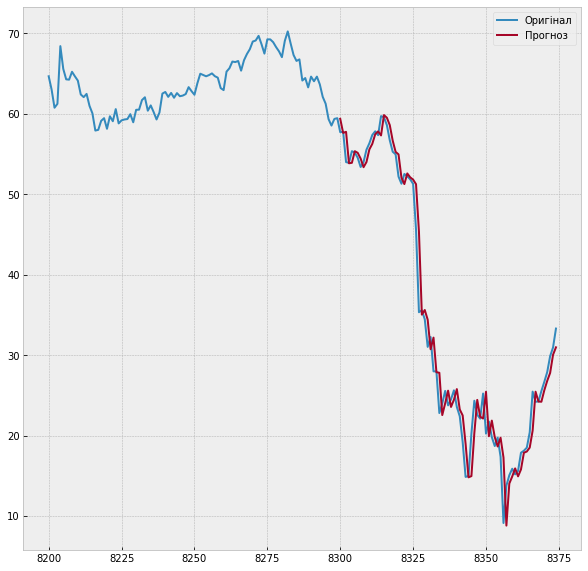

In [51]:
plt.plot(df.price[8200:], label='Оригінал')
plt.plot(arima_pred_recent, label='Прогноз')
plt.legend(loc=1)
